In [1]:
# !kaggle datasets download -d mczielinski/bitcoin-historical-data

/bin/bash: /home/hilbert/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
 93%|███████████████████████████████████▎  | 9.00M/9.69M [00:01<00:00, 7.25MB/s]
100%|██████████████████████████████████████| 9.69M/9.69M [00:01<00:00, 7.94MB/s]


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

# read data

In [8]:
filepath = "data/bitcoin-historical-data.zip"
data = pd.read_csv(filepath)
print(data.shape)
data.head()

(4857377, 8)


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# drop empty rows
data = data.loc[~data.Close.isna()].reset_index(drop=True)
print(data.shape)

(3613769, 8)


<Axes: xlabel='Close', ylabel='Count'>

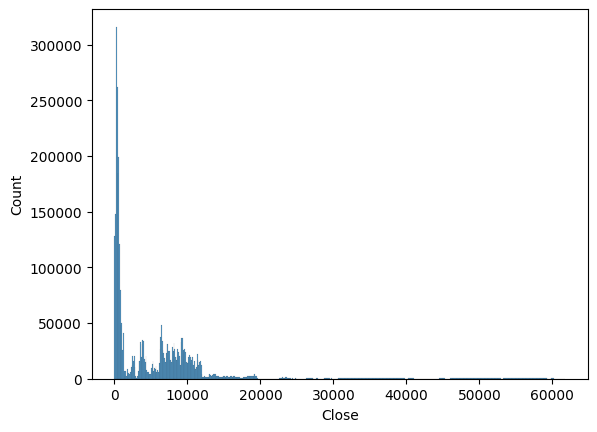

In [11]:
sns.histplot(data.Close)

<Axes: ylabel='Close'>

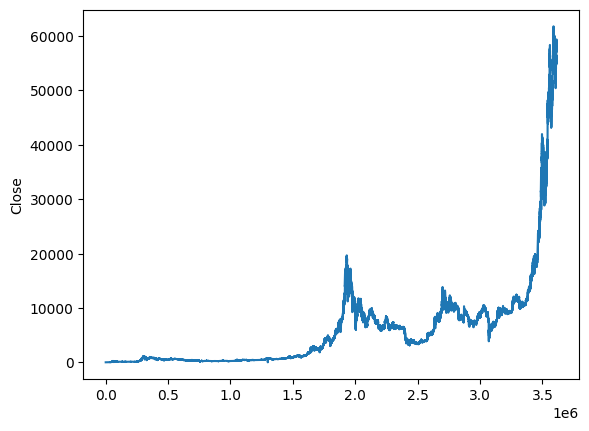

In [12]:
sns.lineplot(data.Close)

# feature processing

In [16]:
# convert unix to datetime
data["dt"] = data.Timestamp.apply(lambda x: datetime.fromtimestamp(x))

# generate datetime features
data["month"] = data.dt.apply(lambda v: v.month)
data["day"] = data.dt.apply(lambda v: v.day)
data["weekday"] = data.dt.apply(lambda v: v.weekday())
data["hour"] = data.dt.apply(lambda v: v.hour)

# drop non-significant columns
data = data.drop(["Timestamp", "dt"], axis=1)

# seet the target & split
target = "Close"
xtr, xts, ytr, yts = train_test_split(
    data.drop(target, axis=1), 
    data[target], 
    test_size=0.2, 
    random_state=42
)

# normalization
scaler = MinMaxScaler()
xtr = scaler.fit_transform(xtr)
xts =scaler.transform(xts)

# dmatrix format
dtrain = xgb.DMatrix(xtr, label=ytr)
dtest = xgb.DMatrix(xts)

In [17]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

model = xgb.train(params, dtrain)
ypr = model.predict(dtest)

metrics = {
    "mae": mean_absolute_error(yts, ypr),
    "mse": mean_squared_error(yts, ypr),
    "rmse": np.sqrt(mean_squared_error(yts, ypr))
}

print(metrics)

{'mae': 170.26833410180168, 'mse': 94643.01804784733, 'rmse': 307.6410539051109}
